In [1]:
import random
from tqdm import tqdm

import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.models as models
from torch.utils.data import random_split
from torchvision.models import resnet18, ResNet18_Weights

import torchinfo
from torchinfo import summary

import torch.nn.functional as F
import pytorch_lightning as pl

# Read Data

In [2]:
transform = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize(
      mean=[0.485, 0.456, 0.406],
      std=[0.229, 0.224, 0.225])])

In [3]:
dataset = datasets.ImageFolder(root='/home/dl_class/data/NEA/NEUdata', transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# PCA on Images of dataset

In [4]:
images = np.array([dataset[i][0].numpy().reshape(-1) for i in range(len(dataset))])
labels = np.array([dataset[i][1] for i in range(len(dataset))])

In [5]:
scaler = StandardScaler()
images_std = scaler.fit_transform(images)

pca = PCA(n_components=0.99, svd_solver='auto')
images = pca.fit_transform(images_std)
pca.explained_variance_ratio_.shape

(598,)

**Note: As the PCA dimenstion is 598. I am keeping the encoder output dimensions close to that, (2*512 = 1024)**

# Auto Encoder
The output of the encode will be of dimensions 1024
No regulization techniques added

In [6]:
class ConvAutoencoder(pl.LightningModule):
    def __init__(self, learning_rate=0.001):
        super(ConvAutoencoder, self).__init__()
        self.learning_rate = learning_rate
        self.criterion = nn.MSELoss()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # 224x224
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 112x112
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 56x56
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 28x28
            nn.ReLU(True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # 14x14
            nn.ReLU(True),
            nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1),  # 7x7
            nn.ReLU(True),
            nn.Conv2d(1024, 1024, kernel_size=7, stride=1, padding=0),  # 1x1
            nn.ReLU(True)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1024, 1024, kernel_size=7, stride=1, padding=0),  # 7x7
            nn.ReLU(True),
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1),  # 14x14
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # 28x28
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 56x56
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 112x112
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 224x224
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def get_latent(self, x):
        encoded = self.encoder(x)
        return encoded.view(-1, 1024)

    def training_step(self, batch, batch_idx):
        images, _ = batch
        outputs = self(images)
        loss = self.criterion(outputs, images)
        self.log("train_loss", loss, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, _ = batch
        outputs = self(images)
        loss = self.criterion(outputs, images)
        self.log("val_loss", loss, on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvAutoencoder()
model.to(device)
summary(model, input_size=(16, 3, 224, 224) , row_settings=("depth", "ascii_only"))

Layer (type:depth-idx)                   Output Shape              Param #
ConvAutoencoder                          [16, 3, 224, 224]         --
+ Sequential: 1-1                        [16, 1024, 1, 1]          --
|    + Conv2d: 2-1                       [16, 32, 224, 224]        896
|    + ReLU: 2-2                         [16, 32, 224, 224]        --
|    + Conv2d: 2-3                       [16, 64, 112, 112]        32,832
|    + ReLU: 2-4                         [16, 64, 112, 112]        --
|    + Conv2d: 2-5                       [16, 128, 56, 56]         131,200
|    + ReLU: 2-6                         [16, 128, 56, 56]         --
|    + Conv2d: 2-7                       [16, 256, 28, 28]         524,544
|    + ReLU: 2-8                         [16, 256, 28, 28]         --
|    + Conv2d: 2-9                       [16, 512, 14, 14]         2,097,664
|    + ReLU: 2-10                        [16, 512, 14, 14]         --
|    + Conv2d: 2-11                      [16, 1024, 7, 7]      

# Split Data in Train, Test and Val

Read Data from Train and split into Train and validation

Read Data from test for Test

**Training : $67 \%$**

**Validation: $23 \%$**

**Testing : $10 \%$**

In [8]:

train_dataset = datasets.ImageFolder(root='/home/dl_class/data/NEA/NEUdata_split/Train', transform=transform)
train_dataset, val_dataset = random_split(
                      train_dataset,
                      [1200, 420])

trainloader = torch.utils.data.DataLoader(
                    train_dataset,
                    batch_size=16,
                    shuffle=True)

valloader = torch.utils.data.DataLoader(
                    val_dataset,
                    batch_size=16,
                    shuffle=True)
test_dataset = datasets.ImageFolder(root='/home/dl_class/data/NEA/NEUdata_split/Test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Training

In [ ]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger


model = ConvAutoencoder()
checkpoint_callback = ModelCheckpoint(monitor="val_loss", save_top_k=1, mode="min")
logger = CSVLogger("logs", name="autoencoder")

trainer = Trainer(
    max_epochs=50,
    accelerator="auto",  # Uses GPU if available
    callbacks=[checkpoint_callback],
    logger=logger
)

trainer.fit(model, train_dataloaders=trainloader, val_dataloaders=valloader)


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | criterion | MSELoss    | 0      | train
1 | encoder   | Sequential | 62.6 M | train
2 | decoder   | Sequ

/home/durga/Hw4/hw4/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/durga/Hw4/hw4/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/durga/Hw4/hw4/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:06<00:00, 11.61it/s, v_num=3]
Validation: |                                                                                                                                                                                | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:05<00:00, 13.68it/s, v_num=3]
Validation: |                                                                                                                                                                                | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:04<00:00, 18.61it/s, v_num=3]


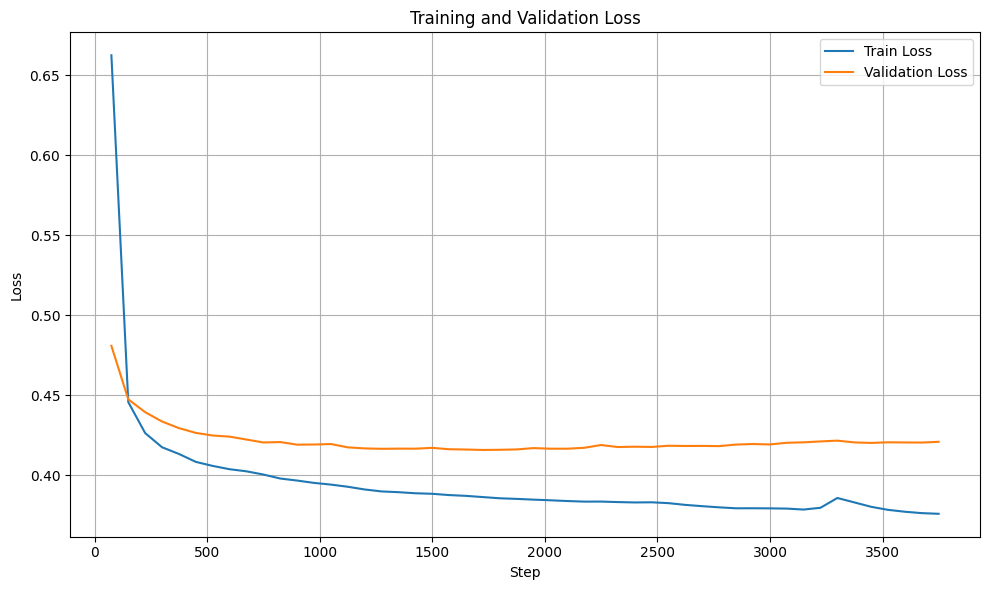

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV log file
log_path = 'logs/autoencoder/version_0/metrics.csv'  
df = pd.read_csv(log_path)

train_loss = df[["step", "train_loss"]].dropna()
val_loss = df[["step", "val_loss"]].dropna()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_loss["step"], train_loss["train_loss"], label="Train Loss")
plt.plot(val_loss["step"], val_loss["val_loss"], label="Validation Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Get Reconstruction

In [16]:
def get_reconstruction(autoencoder,test_dataset):
    autoencoder.to(device)
    autoencoder.eval()
    num_reconstructions = 50
    random_indices = random.sample(range(len(test_dataset)), num_reconstructions)

    reconstructed_images = []
    original_images = []
    original_labels = []
    for idx in random_indices:
        img, label = test_dataset[idx]
        img = img.unsqueeze(0).to(device)

        with torch.no_grad():
            reconstructed_img = autoencoder(img)

        reconstructed_images.append(reconstructed_img.cpu().squeeze())
        original_images.append(img.cpu().squeeze())
        original_labels.append(label)
    return reconstructed_images,original_images,original_labels


In [17]:
reconstructed_images,original_images,original_labels =  get_reconstruction(model,test_dataset)

In [18]:
def plot_reconstruction(reconstructed_images,original_images):
    fig, axes = plt.subplots(2, 10, figsize=(20, 4))
    for i in range(10):
        axes[0, i].imshow(original_images[i].permute(1, 2, 0).clip(0,1))
        axes[1, i].imshow(reconstructed_images[i].permute(1, 2, 0).clip(0,1))
    plt.show()

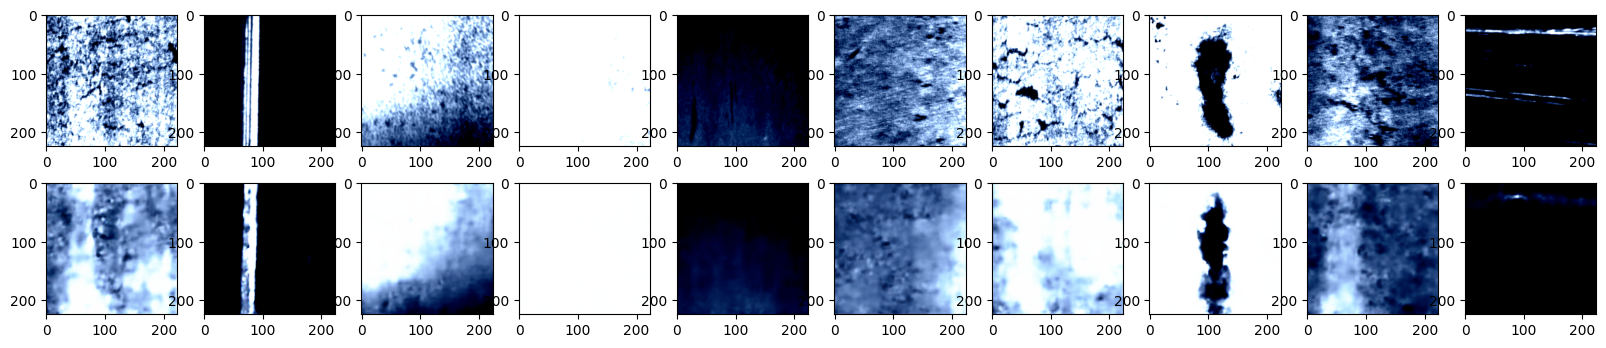

In [19]:
plot_reconstruction(reconstructed_images,original_images)

# Train Clasifier Resnet18

In [20]:
classifier = resnet18(weights=ResNet18_Weights.DEFAULT)
num_classes = len(test_dataset.classes)
classifier.fc = nn.Linear(classifier.fc.in_features, num_classes)
classifier.to(device)

classifier_criterion = nn.CrossEntropyLoss()
classifier_optimizer = optim.Adam(classifier.parameters(), lr=0.001)
num_epochs = 30

progress_bar = tqdm(range(num_epochs), desc=f'Epoch 0/{num_epochs}')

for epoch in progress_bar:
    classifier.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        classifier_optimizer.zero_grad()
        outputs = classifier(images)
        loss = classifier_criterion(outputs, labels)
        loss.backward()
        classifier_optimizer.step()

        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(trainloader)
    epoch_acc = 100 * correct / total

    # Update progress bar with epoch count and metrics
    progress_bar.set_description(f'Epoch {epoch+1}/{num_epochs}')
    progress_bar.set_postfix({
        'loss': f'{epoch_loss:.4f}',
        'acc': f'{epoch_acc:.2f}%'
    })

Epoch 30/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:28<00:00,  2.93s/it, loss=0.1031, acc=97.08%]


## Test accuracy

In [21]:
def clasifier_test_accuracy(classifier,test_loader):
    classifier.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = classifier(images)
            _, predicted = outputs.max(1)

            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_acc = 100 * correct / total
    print(f"Test Accuracy on Original NEU Data: {test_acc:.2f}%")

In [22]:
clasifier_test_accuracy(classifier,test_loader)

Test Accuracy on Original NEU Data: 98.33%


# Accuracy of Reconstruction and orginal

In [23]:
def compare_reconstruction_orginal(classifier,reconstructed_images,original_images,original_labels):
    classifier.eval()
    or_correct = 0
    re_correct = 0

    with torch.no_grad():
        i=0
        for re_image, or_image in zip(reconstructed_images,original_images):
            re_image = re_image.unsqueeze(0)
            or_image = or_image.unsqueeze(0)
            re_outputs = classifier(re_image.to(device))
            or_outputs = classifier(or_image.to(device))
            _, re_predicted = re_outputs.max(1)
            _, or_predicted = or_outputs.max(1)

            or_correct += or_predicted.eq(original_labels[i]).sum().item()
            re_correct += re_predicted.eq(original_labels[i]).sum().item()

            i=i+1

    or_test_acc = 100 * or_correct / len(reconstructed_images)
    re_test_acc = 100 * re_correct / len(reconstructed_images)

    print(f"Test Accuracy on Reconstructed NEU Data: {re_test_acc:.2f}% Text Accuracy on the same orginal images is {or_test_acc:.2f}% " )

In [24]:
compare_reconstruction_orginal(classifier,reconstructed_images,original_images,original_labels)

Test Accuracy on Reconstructed NEU Data: 24.00% Text Accuracy on the same orginal images is 94.00% 


# Architecture A (Added Regularization, weigth Init and Sxcheduler)

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl

class LitConvAutoencoder(pl.LightningModule):
    def __init__(self, lr=1e-3, weight_decay=1e-4, l1_lambda=1e-4):
        super().__init__()
        self.save_hyperparameters()

        self.dropout_rate = 0.2
        self.criterion = nn.MSELoss()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Dropout2d(self.dropout_rate),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Dropout2d(self.dropout_rate),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Dropout2d(self.dropout_rate),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Dropout2d(self.dropout_rate),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, padding=1),
            nn.ReLU(True),
            nn.Dropout2d(self.dropout_rate),

            nn.ConvTranspose2d(64, 32, 3, padding=1),
            nn.ReLU(True),
            nn.Dropout2d(self.dropout_rate),

            nn.ConvTranspose2d(32, 16, 3, padding=1),
            nn.ReLU(True),
            nn.Dropout2d(self.dropout_rate),

            nn.ConvTranspose2d(16, 3, 3, padding=1),
            nn.Tanh(),
        )

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def training_step(self, batch, batch_idx):
        images, _ = batch
        outputs = self(images)
        reconstruction_loss = self.criterion(outputs, images)

        # L1 Regularization
        l1_reg = sum(torch.norm(p, 1) for p in self.parameters())
        loss = reconstruction_loss + self.hparams.l1_lambda * l1_reg

        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, _ = batch
        outputs = self(images)
        loss = self.criterion(outputs, images)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(), 
            lr=self.hparams.lr, 
            weight_decay=self.hparams.weight_decay
        )
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'epoch'
            }
        }

In [26]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger

autoencoder = LitConvAutoencoder()
autoencoder.to(device)

checkpoint_cb = ModelCheckpoint(monitor="val_loss", save_top_k=1, mode="min")
logger = CSVLogger("logs", name="autoencoder")

trainer = Trainer(
    max_epochs=50,
    accelerator="auto",
    devices="auto",
    callbacks=[checkpoint_cb],
    logger=logger,
    gradient_clip_val=1.0
)

trainer.fit(autoencoder, train_dataloaders=trainloader, val_dataloaders=valloader)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | criterion | MSELoss    | 0      | train
1 | encoder   | Sequential | 97.9 K | train
2 | decoder   | Sequential | 97.3 K | train
-------------------------------------------------
195 K     Trainable params
0         Non-trainable params
195 K     Total params
0.781     Total estimated model params size (MB)
30        Modules in train mode
0         Modules in eval mode


/home/durga/Hw4/hw4/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/durga/Hw4/hw4/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/durga/Hw4/hw4/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:05<00:00, 14.81it/s, v_num=4]
Validation: |                                                                                                                                                                                | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:05<00:00, 14.91it/s, v_num=4, val_loss=0.172, train_loss=0.915]
Validation: |                                                                                                                                                                                | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:05<0

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:05<00:00, 13.19it/s, v_num=4, val_loss=0.168, train_loss=0.687]


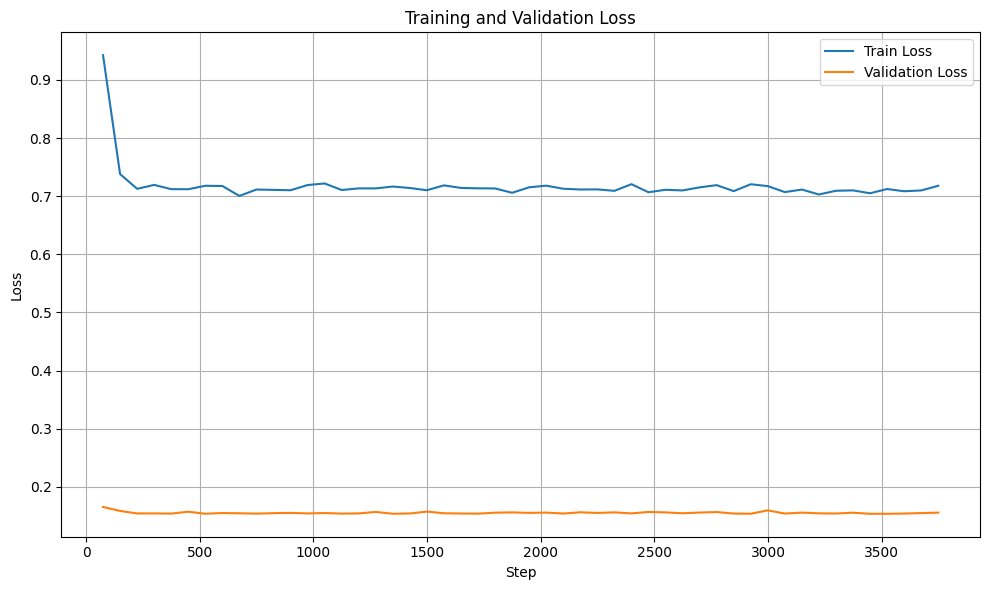

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV log file
log_path = 'logs/autoencoder/version_1/metrics.csv'  
df = pd.read_csv(log_path)

train_loss = df[["step", "train_loss"]].dropna()
val_loss = df[["step", "val_loss"]].dropna()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_loss["step"], train_loss["train_loss"], label="Train Loss")
plt.plot(val_loss["step"], val_loss["val_loss"], label="Validation Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [28]:
reconstructed_images,original_images,original_labels =  get_reconstruction(autoencoder,test_dataset)

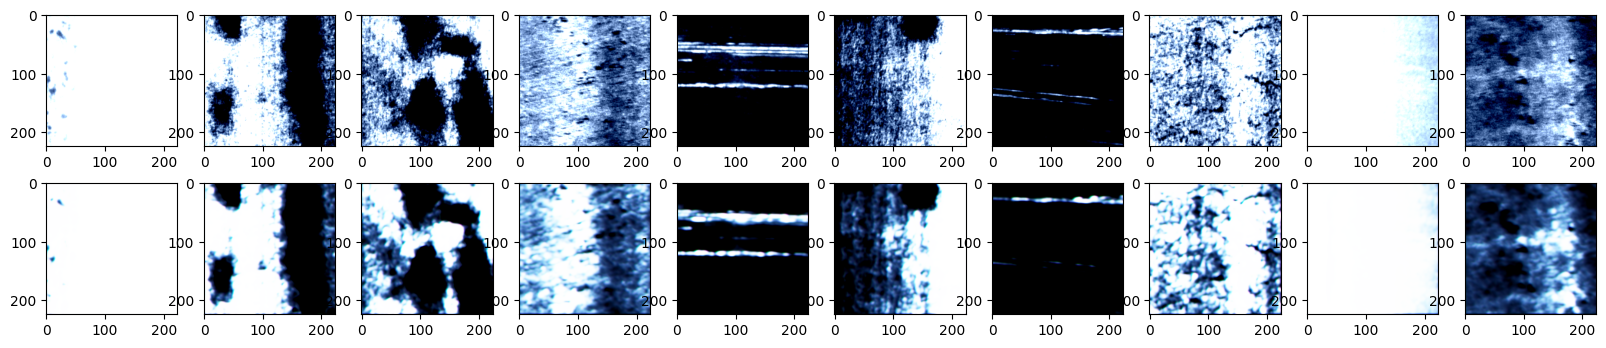

In [29]:
plot_reconstruction(reconstructed_images,original_images)

**Note: Use this model the reconstruction images are better than the previous model (with out Regulization).**

**The reconstruction and original images are indistinguible for human perception**

In [30]:
compare_reconstruction_orginal(classifier,reconstructed_images,original_images,original_labels)

Test Accuracy on Reconstructed NEU Data: 52.00% Text Accuracy on the same orginal images is 100.00% 


**Accuracy increased dractically, still lower than the orginal images**